In [1]:
import controllers
import controlpy
import control_utils
import dynamics_models
import numpy as np
import polytope
import system_id
import tqdm
import uncertainty_utils
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('font', serif='Times')
plt.rc('font', size=16)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

In [2]:
class NonLinSpringDamper(dynamics_models.NonLinearSystem):
    """
    d^2x/dt^2 = -k(x)/m * x - c/m * (dx/dt) + 1/m * u
    k(x) = k * (1 - alpha * x^2)
    """
    
    def __init__(self, init_state, dt, process_noise):
        super(NonLinSpringDamper, self).__init__(2, 1, init_state, dt, process_noise, use_ode_integrator=True)
        self.k = 10
        self.m = 1
        self.alpha = .5
        self.c = .5
        
    def k_func(self, x1):
        return self.k * (1 - self.alpha * x1**2)
    
    def f_continuous(self, state, u):
        x, dx = state
        u = u[0]
        ddx = - (1 / self.m) * (self.k * (x - self.alpha * x **3) + self.c * dx - u)
        return np.array([dx, ddx])
        
    def get_jacobians(self, x_bar, u_bar):
        Jx = np.zeros((self.n_states, self.n_states))
        Jx[0,1] = 1
        Jx[1,0] = - (self.k / self.m) * (1 - 3 * self.alpha * x_bar[0] **2)
        Jx[1,1] = - (self.c / self.m)
        
        Ju = np.zeros((self.n_states, self.n_inputs))
        Ju[1,0] = 1 / self.m
        return Jx, Ju

In [3]:
dt = 0.1
n = 2
m = 1
save_dir = "sysid_examples/"
init_state = np.array([1,0])
process_noise_var = 1e-3
process_noise = 1e-3 * np.eye(n)
input_noise_std = 1e-1
figsize = (8,5)
xlims = (-.5,1.5)
ylims = (-2,1)

def get_vehicle():
    init_state_noisy = np.random.multivariate_normal(init_state, 0.1 * process_noise)
    return NonLinSpringDamper(init_state_noisy, dt, process_noise)

vehicle = get_vehicle()

In [4]:
x_bar = np.zeros(n)
u_bar = np.zeros(m)
A, B, C = vehicle.get_linearization(x_bar, u_bar, dt)

Q = np.eye(n)
R = np.eye(m)
K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q, R)

In [5]:
def sim_traj(vehicle, K, episode_length):
    x_traj = [vehicle.x]
    u_traj = []
    for _ in range(episode_length):
        u = - K @ x_traj[-1] + np.random.randn() * input_noise_std
        x_next = vehicle.f(u)

        x_traj.append(x_next)
        u_traj.append(u)
    return x_traj, u_traj

In [6]:
num_episodes = 5
title_string = "smalldata" if num_episodes <=3 else "largedata"
title_string = "nonoise"
episode_length = 40
x_trajs = []
u_trajs = []
for i in tqdm.tqdm(range(num_episodes)):
    vehicle = get_vehicle()
    x_traj, u_traj = sim_traj(vehicle, K, episode_length)
    x_trajs.append(np.array(x_traj))
    u_trajs.append(np.array(u_traj))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.39it/s]


In [7]:
h = .2
lamb = 1e-1
model = system_id.LocalLinearModel(n, m, h, lamb)

for x_traj, u_traj in zip(x_trajs, u_trajs):
    model.add_trajectory(x_traj, u_traj)
n_test = 100
test_x = np.linspace(*xlims, num=n_test)
test_y = np.linspace(*ylims, num=n_test)
test_points = np.array(list(itertools.product(test_x, test_y)))
test_inputs = - test_points @ K.T
x_test = np.hstack((test_points, test_inputs))

predictions, uncertainties = model.predict(test_points, test_inputs)
base_uncertainties = uncertainties
uncertainties = (uncertainties + 1) * process_noise_var


In [8]:
f_true = lambda x, u: vehicle.f_discrete(x, u, dt)
true_predictions = [f_true(x, u) for x, u in zip(np.rollaxis(test_points,0), np.rollaxis(test_inputs,0))]
pred_errors = np.linalg.norm(predictions - true_predictions, axis=1)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


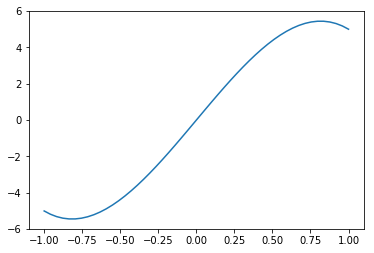

In [9]:
ks = [vehicle.k_func(x1) * x1 for x1 in np.linspace(-1,1)]
plt.plot(np.linspace(-1,1), ks)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


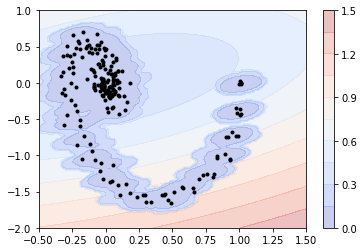

In [10]:
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
clim = (0,10)
plt.xlim(xlims)
plt.ylim(ylims)
plt.contourf(test_x, test_y, 3 * np.sqrt(uncertainties.reshape((len(test_x), len(test_y))).T), 10, alpha=0.3, cmap="coolwarm")
plt.colorbar()
# plt.clim(clim)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


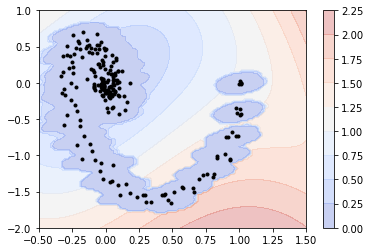

In [11]:
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
plt.xlim(xlims)
plt.ylim(ylims)
plt.contourf(test_x, test_y, pred_errors.reshape((len(test_x), len(test_y))).T, 10, alpha=0.3, cmap="coolwarm")
plt.colorbar()
# plt.clim(clim)

In [12]:
vehicle = get_vehicle()
# K, _, _ = controlpy.synthesis.controller_lqr_discrete_time(A, B, Q , R * 10)
x_traj, u_traj = sim_traj(vehicle, K, episode_length)
x_traj = np.array(x_traj)
u_traj = np.array(u_traj)
As, Bs, Cs, Covs, errors = model.regress_models(x_traj, u_traj)

In [13]:
z_test = np.hstack((x_test, np.ones((x_test.shape[0], 1))))
uncertainties_along_trajs = []
for cov in Covs:
    uncertainty_along_traj = [z.T @ cov @ z for z in np.rollaxis(z_test, 0)]
    uncertainties_along_trajs.append(uncertainty_along_traj)
uncertainties_along_trajs = np.vstack(uncertainties_along_trajs)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


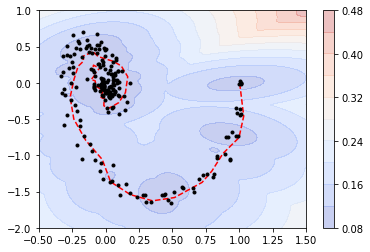

In [14]:
min_uncertainties_along_traj = np.min(uncertainties_along_trajs, axis=0)
min_uncertainties_along_traj = (1 + min_uncertainties_along_traj) * process_noise_var
plt.plot(x_traj[:,0], x_traj[:,1], "r--")
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
plt.xlim(xlims)
plt.ylim(ylims)
plt.contourf(test_x, test_y, 3 * np.sqrt(min_uncertainties_along_traj.reshape((len(test_x), len(test_y))).T), 10, alpha=0.3, cmap="coolwarm")
cbar = plt.colorbar()
# cbar.set_clim(clim)

## Evecs

In [15]:
# n_test = 50
test_x = np.linspace(*xlims, num=n_test)
test_y = np.linspace(*ylims, num=n_test)
test_points = np.array(list(itertools.product(test_x, test_y)))
test_inputs = - test_points @ K.T

As, Bs, Cs, Covs, errors = model.regress_models(test_points, test_inputs)
e_decomps = [np.linalg.eig(cov) for cov in Covs]
# [print(np.min(evals)) for evals, evecs in e_decomps]
evecs = [evecs[:2,np.argmin(evals)] for evals, evecs in e_decomps]
evecs = np.array(evecs)

(-2, 1)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


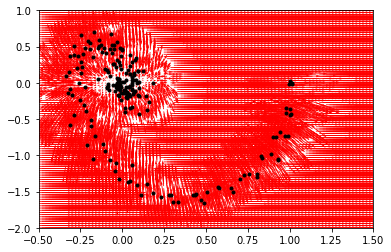

In [16]:
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
plt.quiver(test_points[:,0], test_points[:,1], evecs[:,0], evecs[:,1], color="r", scale=10)
plt.xlim(xlims)
plt.ylim(ylims)

## GP

In [27]:
x_data = model.X
y_data = model.Y
print(x_data.shape)
print(y_data.shape)
kernel = RBF(length_scale=1e-3) + WhiteKernel(noise_level=process_noise_var)
gp = GaussianProcessRegressor(kernel=kernel).fit(x_data, y_data)
predictions, covs = gp.predict(x_test, return_cov=True)
uncertainties = np.diag(covs)
pred_errors = np.linalg.norm(predictions - true_predictions, axis=1)

(200, 3)
(200, 2)


## Pred error

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


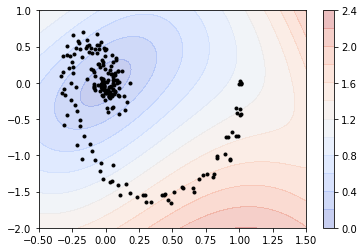

In [28]:
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
plt.xlim(xlims)
plt.ylim(ylims)
plt.contourf(test_x, test_y, pred_errors.reshape((len(test_x), len(test_y))).T, 10, alpha=0.3, cmap="coolwarm")
plt.colorbar()
# plt.clim(clim)

C:\Users\rohan\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


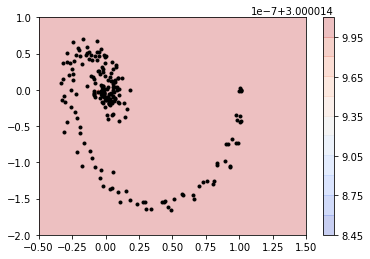

In [29]:
for x_traj in x_trajs:
    plt.plot(x_traj[:,0], x_traj[:,1], "k.")
clim = (0,10)
plt.xlim(xlims)
plt.ylim(ylims)
plt.contourf(test_x, test_y, 3 * np.sqrt(uncertainties.reshape((len(test_x), len(test_y))).T), 10, alpha=0.3, cmap="coolwarm")
plt.colorbar()

In [26]:
len(test_x)

100